#CMU analysis for Milestone 2
##In this notebook we provide initial analysis and preprocessing of the CMU dataset 

In [ ]:
# For convenience, we store data on Google Drive. 
# Here there are some instructions, how to work with drive in colab

from google.colab import drive


drive.mount('/content/drive') 
cmu_root = "drive/MyDrive/ADA/MovieSummaries"

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import json
from functools import partial

In [ ]:
# Load the data on movies and summaries and merge them on movie id
columns = [
    'wikipedia_id',
    'freebase_id',
    'name',
    'release_date',
    'box_office_revenue',
    'runtime',
    'languages',
    'countries',
    'genres',
]

movies = pd.read_csv(Path(cmu_root, 'movie.metadata.tsv'), sep='\t', quotechar='"', names=columns,)
summaries = pd.read_csv(Path(cmu_root, 'plot_summaries.txt'), sep='\t', header=None, names=['wikipedia_id', 'summary'])
movies_summaries = pd.merge(left=movies, right=summaries, on='wikipedia_id', how='left')  

#Convert release date to datetime format
movies_summaries['release_date'] = movies_summaries['release_date'].apply(partial(pd.to_datetime, errors='coerce'))

print(f'Movies that don\'t have summaries: {len(set(movies["wikipedia_id"].values) - set(summaries["wikipedia_id"].values))}')
print(f'Summaries that aren\'t matching any movie: {len(set(summaries["wikipedia_id"].values) - set(movies["wikipedia_id"].values))}')  
print(f'Movies dataframe: {len(movies)}')
print(f'Summaries dataframe: {len(summaries)}')
print(f'Merged dataframe: {len(movies_summaries)}')
movies_summaries.head()

Movies that don't have summaries: 39537
Summaries that aren't matching any movie: 99
Movies dataframe: 81741
Summaries dataframe: 42303
Merged dataframe: 81741


,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."


## Initial data analysis

We will have a look at the data we have

In [ ]:
print(movies_summaries.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81741 entries, 0 to 81740
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   wikipedia_id        81741 non-null  int64         
 1   freebase_id         81741 non-null  object        
 2   name                81741 non-null  object        
 3   release_date        74838 non-null  datetime64[ns]
 4   box_office_revenue  8401 non-null   float64       
 5   runtime             61291 non-null  float64       
 6   languages           81741 non-null  object        
 7   countries           81741 non-null  object        
 8   genres              81741 non-null  object        
 9   summary             42204 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 6.9+ MB
None


In [ ]:
# Check for uniqueness
print(f'`wikipedia_id` is unique: {movies_summaries["wikipedia_id"].is_unique}')
print(f'`freebase_id` is unique: {movies_summaries["freebase_id"].dropna().is_unique}')
print(f'`name` is unique: {movies_summaries["name"].dropna().is_unique}')

# Example of two non-unique names:
movies_summaries[movies_summaries['name'] == 'Henry V']

`wikipedia_id` is unique: True
`freebase_id` is unique: True
`name` is unique: False


,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,summary
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
74819,80493,/m/0ktqc,Henry V,1944-01-01,NaN,135.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/04xvh5"": ""Costume drama"", ""/m/0520lz"": ""R...",We first see a panorama of London in 1600. We...


In [ ]:
# Parsing 'genres', 'languages' and 'countries' columns
# Putting everything into a list

movies_summaries['languages'] = movies_summaries.apply(lambda m: list((json.loads(m.languages)).values()), axis=1)
movies_summaries['countries'] = movies_summaries.apply(lambda m: list((json.loads(m.countries)).values()), axis=1)
movies_summaries['genres'] = movies_summaries.apply(lambda m: list((json.loads(m.genres)).values()), axis=1)
movies_summaries.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra..."


In [ ]:
# Create 3 new separate dataFrames for columns 'genres', 'languages', 'countries'
# One-to-many tables

def get_new_table_by_column(df, index, column):
  column_list = []
  for id, row in df.iterrows():
    column_list += [[row[index], column_value] for column_value in row[column]]


  column_table = pd.DataFrame(column_list, columns=[index, column])
  return column_table

movie_genres = get_new_table_by_column(movies_summaries, 'freebase_id', 'genres')
movie_languages = get_new_table_by_column(movies_summaries, 'freebase_id', 'languages')
movie_countries = get_new_table_by_column(movies_summaries, 'freebase_id', 'countries')

movie_genres.head()

,freebase_id,genres
0,/m/03vyhn,Thriller
1,/m/03vyhn,Science Fiction
2,/m/03vyhn,Horror
3,/m/03vyhn,Adventure
4,/m/03vyhn,Supernatural


###To evaluate the success of films, we added review scores and oscar awards to our dataset
We can create queries to Wikidata using SPARQL and retreive the information

Below is the query for retreiving review scores. We retreive only averaged scores from Rotten Tomato.

```
SELECT    ?filmLabel ?freebaseId ?reviewScore ?time ?timeLabel WHERE {
 ?film wdt:P31 wd:Q11424;
       wdt:P646 ?freebaseId;
       p:P444 ?reviewStatement.
 ?reviewStatement pq:P447 wd:Q105584;
                  ps:P444 ?reviewScore;
                  pq:P459 wd:Q108403540;
                  pq:P585 ?time

   SERVICE wikibase:label {
    bd:serviceParam wikibase:language "en" .
   }
 }

```

This query is for retrieving films that recieved at least one of the Academy Awards.
```
SELECT  ?filmLabel ?freebaseId ?awardLabel ?time WHERE {
 ?film wdt:P31 wd:Q11424;
       wdt:P646 ?freebaseId;
       p:P166 ?awardStatement.
 ?awardStatement ps:P166 ?award;
                 pq:P585 ?time.
 ?award wdt:P31 wd:Q19020.


   SERVICE wikibase:label {
    bd:serviceParam wikibase:language "en" .
   }
 }

```

In [ ]:
# Load the reviews dataframe 
# And convert fraction strings to float

wikidata_root = "drive/MyDrive/ADA/WikiData"

def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0

        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac


reviews = pd.read_csv(Path(wikidata_root, 'reviews_new.csv'))
reviews = reviews[reviews['reviewScore'].str.contains('/')]
# all the scores are floats in range [0, 10]
reviews['reviewScore'] = reviews['reviewScore'].apply(lambda x: convert_to_float(x.replace(',', '.')) * 10)  
reviews.head()

,filmLabel,freebaseId,reviewScore,time,timeLabel
0,Ichi,/m/0bmdc0z,5.7,2021-10-05T00:00:00Z,2021-10-05T00:00:00Z
1,Il Divo,/m/04lqvlr,7.5,2021-10-05T00:00:00Z,2021-10-05T00:00:00Z
2,Dying Breed,/m/04yb2dq,4.8,2021-10-05T00:00:00Z,2021-10-05T00:00:00Z
3,The Spy in Black,/m/04p50b,7.8,2021-10-05T00:00:00Z,2021-10-05T00:00:00Z
4,I Know Where I'm Going!,/m/03sndz,8.7,2021-10-05T00:00:00Z,2021-10-05T00:00:00Z


In [ ]:
# Merging review with our movies_summaries dataset
movies_reviews = pd.merge(left=movies_summaries, right=reviews, left_on='freebase_id', right_on='freebaseId', how='inner', suffixes=('', ''))

In [ ]:
movies_reviews.drop(['freebaseId', 'filmLabel', 'timeLabel'], axis=1, inplace=True)

print(f'Size of movies_summaries dataframe: {len(movies_summaries)}')
print(f'Size of reviews dataframe: {len(reviews)}')
print(f'Size of merged dataframe: {len(movies_reviews)}')

movies_reviews.head()

Size of movies_summaries dataframe: 81741
Size of reviews dataframe: 17489
Size of merged dataframe: 13985


,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,summary,reviewScore,time
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",3.8,2021-10-05T00:00:00Z
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,5.8,2021-10-09T00:00:00Z
2,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",NaN,7.0,2021-10-07T00:00:00Z
3,2345652,/m/075f66,City of the Dead,1960-01-01,NaN,76.0,[English Language],[United Kingdom],"[Horror, Supernatural]",NaN,5.9,2021-10-05T00:00:00Z
4,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,8.2,2021-10-05T00:00:00Z


###Oscars

We have data on Academy Awards. It contains Freebase IDs and can be merged with our dataset.

In [ ]:
# Load oscars data
oscars = pd.read_csv(Path(wikidata_root, 'oscars_new.csv'))

print(f'Size of oscars dataframe: {len(oscars)}')
oscars.head()


Size of oscars dataframe: 1546


,filmLabel,freebaseId,awardLabel,time
0,The King's Speech,/m/09gq0x5,"Academy Award for Best Writing, Original Scree...",2009-01-01T00:00:00Z
1,The King's Speech,/m/09gq0x5,Academy Award for Best Picture,2011-01-01T00:00:00Z
2,How the West Was Won,/m/0jvt9,"Academy Award for Best Writing, Original Scree...",1962-01-01T00:00:00Z
3,A Beautiful Mind,/m/09m6kg,Academy Award for Best Picture,2002-01-01T00:00:00Z
4,The Crying Game,/m/07j8r,"Academy Award for Best Writing, Original Scree...",1991-01-01T00:00:00Z


###Now let's look at the distributions and trends over time of some features

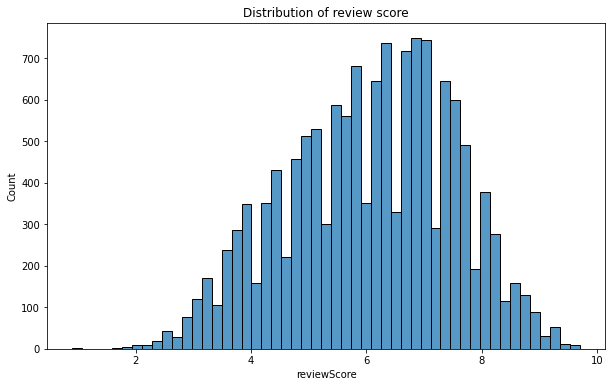

In [ ]:
# Distribution of review score
plt.figure(figsize=(10, 6))
sns.histplot(movies_reviews['reviewScore']).set(title='Distribution of review score')
plt.show()

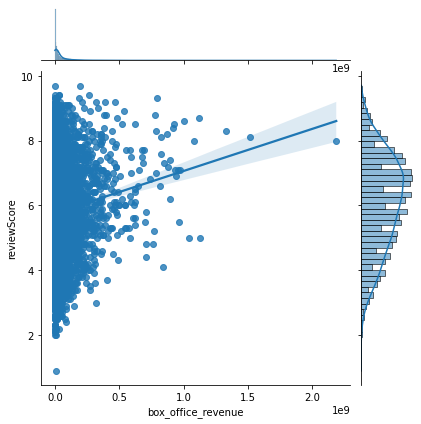

In [ ]:
# Review score and box revenue
sns.jointplot(data=movies_reviews, y='reviewScore', x='box_office_revenue', kind='reg')
plt.show()

In [ ]:
tmp = movies_reviews.copy()
tmp.dropna(inplace=True)
tmp['release_year'] = tmp['release_date'].apply(lambda x: x.year)

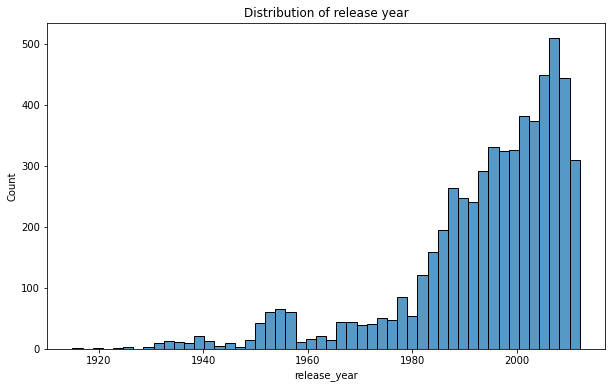

In [ ]:
# Distribution of the film release year
plt.figure(figsize=(10, 6))
sns.histplot(tmp['release_year'], bins=50).set(title='Distribution of release year')
plt.show()

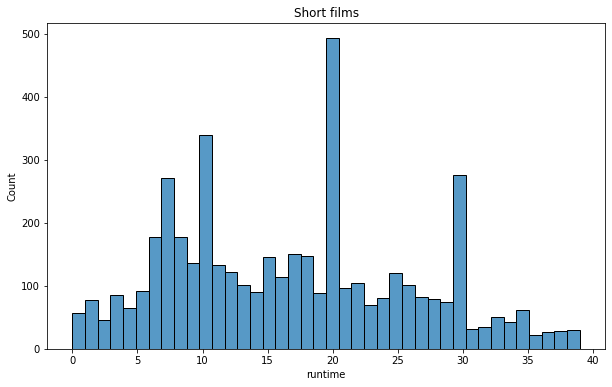

In [ ]:
# Short films by definition are of less than 40 minutes
# https://en.wikipedia.org/wiki/Short_film

shorts = movies_summaries[movies_summaries['runtime'] < 40]
plt.figure(figsize=(10, 6))
sns.histplot(shorts['runtime'], bins=40)
plt.title('Short films')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


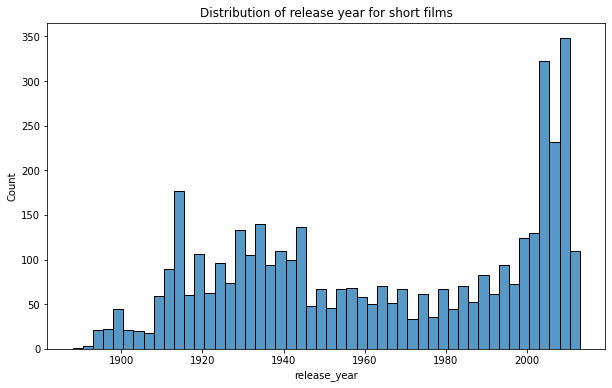

In [ ]:
# Distribution of release year for short films
shorts['release_year'] = shorts['release_date'].apply(lambda x: x.year)
plt.figure(figsize=(10, 6))
sns.histplot(shorts['release_year'], bins=50).set(title='Distribution of release year for short films')
plt.show()

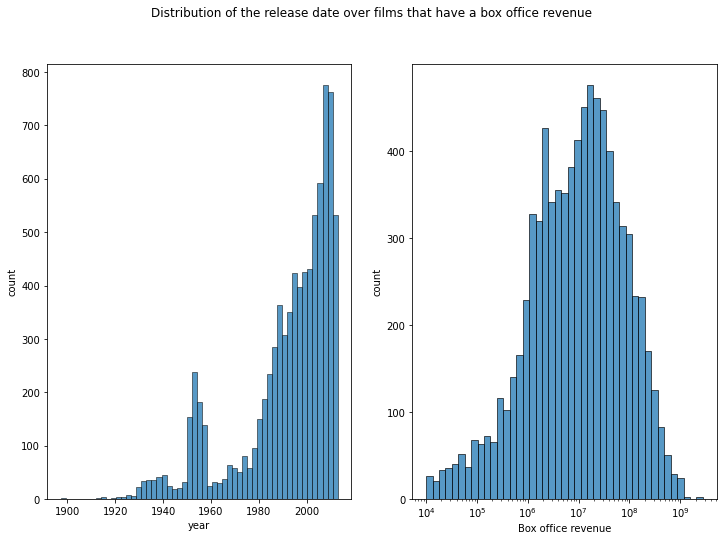

In [ ]:
# Check the distribution of the release date over films that have a box office revenue

revenue_date = movies_summaries[movies_summaries['box_office_revenue'].notna()][['release_date', 'box_office_revenue']].dropna()
revenue_date['release_year'] = revenue_date['release_date'].apply(lambda x: x.year)

# A strange peak around 1950s
plt.figure(figsize=(12, 8))
plt.suptitle('Distribution of the release date over films that have a box office revenue')
plt.subplot(121)
sns.histplot(revenue_date['release_date'])
plt.xlabel('year')
plt.ylabel('count')

plt.subplot(122)
sns.histplot(revenue_date['box_office_revenue'], log_scale=True)
plt.xlabel('Box office revenue')
plt.ylabel('count')
plt.show()

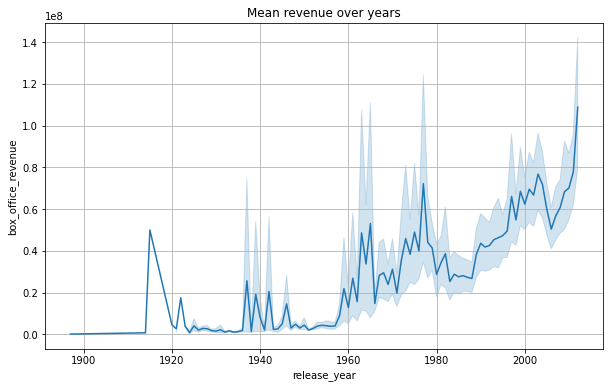

In [ ]:
# Mean revenue over years
plt.figure(figsize=(10, 6))
sns.lineplot(data=revenue_date, x='release_year', y='box_office_revenue',)
plt.title('Mean revenue over years')
plt.grid()
plt.show()

# should be some outliers in the 1920's. Interesting pattern of periodicity

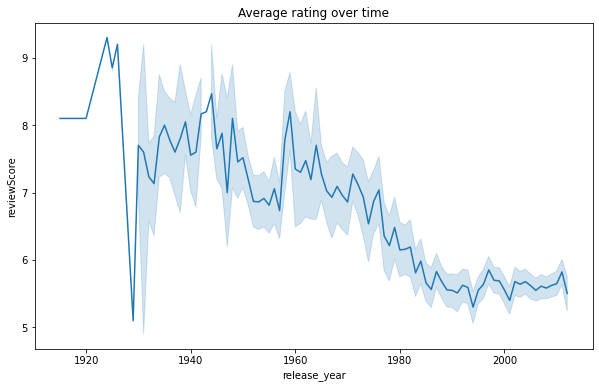

In [ ]:
# Average rating over time (years).
plt.figure(figsize=(10, 6))
sns.lineplot(data=tmp, x='release_year', y='reviewScore').set(title='Average rating over time')
plt.show()

`runtime` contains NaN: True
`runtime` is unique: False
1% of films are shorter than 7.00 minutes
5% of films are shorter than 20.00 minutes
1% of films are longer than 191.10 minutes


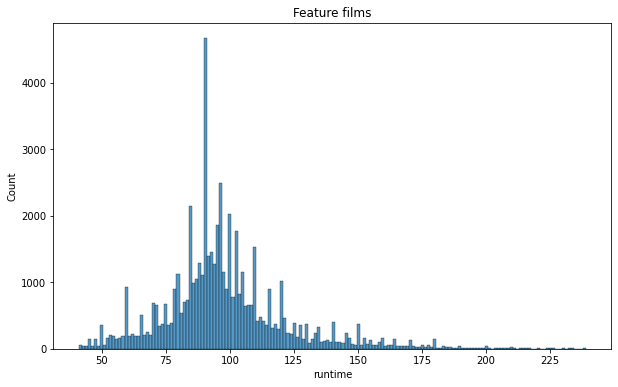

In [ ]:
# Distribution of the runtime

# Interesting feature here
# These periodical peaks are runtime is a multiple of 5
# Most descriptions for simplicity rounded the runtime to the multiple of 5

print(f'`runtime` contains NaN: {movies_summaries["runtime"].isna().any()}')
print(f'`runtime` is unique: {movies_summaries["runtime"].dropna().is_unique}')

tmp = movies_summaries['runtime'].dropna()
print(f'1% of films are shorter than {tmp.quantile(0.01):.2f} minutes')
print(f'5% of films are shorter than {tmp.quantile(0.05):.2f} minutes')
print(f'1% of films are longer than {tmp.quantile(0.99):.2f} minutes')

plt.figure(figsize=(10, 6))
sns.histplot(tmp[(tmp > 40) & (tmp < 240)])
plt.title('Feature films')
plt.show()

###Process characters dataset

In [ ]:
# Load characters metadata
columns = [
    'film_wikipedia_id',
    'film_freebase_id',
    'release_date',
    'character_name',
    'actor_birth_date',
    'gender',
    'height',
    'ethnicity',
    'act_name',
    'act_age',
    'actor_character_map_id',
    'character_freeabase_id',
    'actor_freebase_id'
]

characters = pd.read_csv(Path(cmu_root, 'character.metadata.tsv'), sep='\t', quotechar='"', error_bad_lines=False, names=columns)
characters.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,film_wikipedia_id,film_freebase_id,release_date,character_name,actor_birth_date,gender,height,ethnicity,act_name,act_age,actor_character_map_id,character_freeabase_id,actor_freebase_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


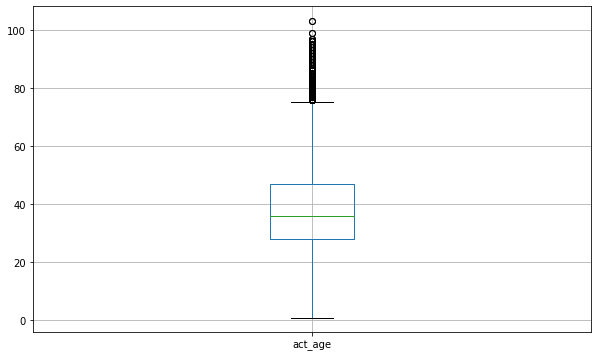

In [ ]:
# Boxplot of actors ages
plt.figure(figsize=(10, 6))
characters[['act_age']].dropna()[characters[['act_age']] > 0].boxplot()
plt.show()

In [ ]:
# Check the difference between the number of male and female actors

#Convert release date to datetime format
characters['release_date'] = characters['release_date'].apply(partial(pd.to_datetime, errors='coerce'))

gender_date = characters[['release_date', 'gender']].dropna()
gender_date['release_year'] = gender_date['release_date'].apply(lambda x: x.year) 

male = gender_date[gender_date['gender'] == 'M'].groupby('release_year').count()
female = gender_date[gender_date['gender'] == 'F'].groupby('release_year').count()

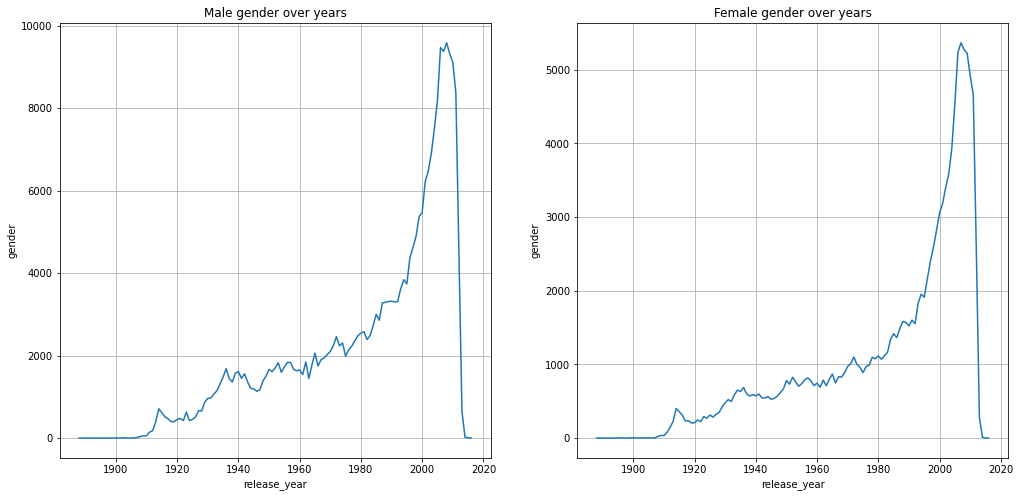

In [ ]:
# We can see, that amount of men ~2 times higher than women (doesn't depend on the period)
plt.figure(figsize=(17, 8))
plt.subplot(121)
sns.lineplot(data=male, x='release_year', y='gender')
plt.title('Male gender over years')
plt.grid()

plt.subplot(122)
sns.lineplot(data=female, x='release_year', y='gender',)
plt.title('Female gender over years')
plt.grid()
plt.show()

In [ ]:
# Check how the average age of the actors changes over time
age_date = characters[['release_date', 'act_age']].dropna()
age_date['release_year'] = age_date['release_date'].apply(lambda x: x.year) 

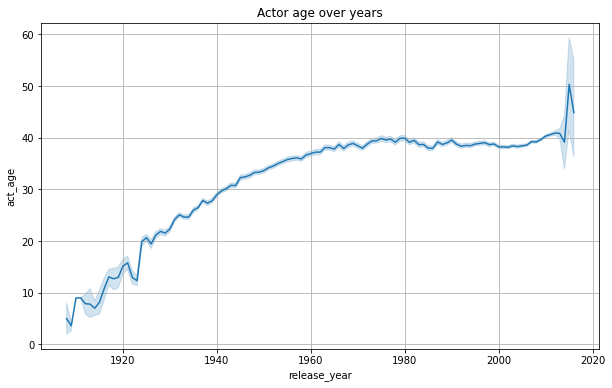

In [ ]:
# It can be seen that the average age of the actors increases with time. 
# This can be explained by the fact that filmmakers prefer to invite more famous and experienced actors.
# There is a plateau here between 1970 and 2010, as well as a jump in the region of recent years. While I find it difficult to explain them
plt.figure(figsize=(10, 6))
sns.lineplot(data=age_date[age_date['act_age'] > 0], x='release_year', y='act_age')
plt.title('Actor age over years')
plt.grid()
plt.show()

In [ ]:
# And what about the change of the height over the time?
height_date = characters[['release_date', 'height']].dropna()
height_date['release_year'] = height_date['release_date'].apply(lambda x: x.year) 

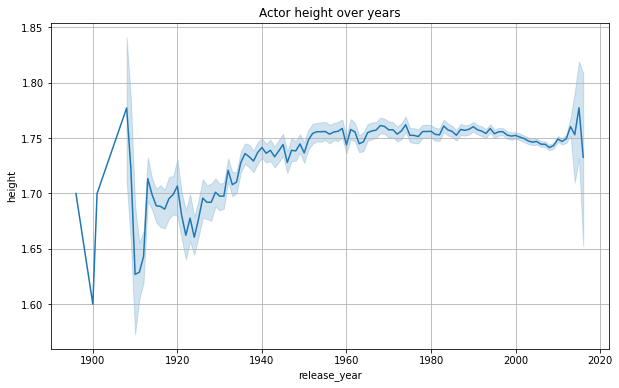

In [ ]:
# Here you can see strange fluctuations around 1910, around the same time that there were strange fluctuations in box office revenue
plt.figure(figsize=(10, 6))
sns.lineplot(data=height_date[height_date['height'] < 3], x='release_year', y='height')
plt.title('Actor height over years')
plt.grid()
plt.show()

### Subtitles

`Subtitles` dataset preprocessing (https://www.kaggle.com/datasets/adiamaan/movie-subtitle-dataset)

We merge this dataset with our source dataset. And then for each genre we count the wordcloud of the main words that appear in the subtitles of movies of that genre, using the `tf-idf` model (we use `sklearn.feature_extraction.text.TfidfVectorizer`)

In [ ]:
# Load the data on subtitles and merge it with our main dataset 
# Using wikidata, we got the merge_ids table (in 'merge_ids.csv' file), which contains freebase_id and imdb_id
# Through this table, we are merging the dataset with subtitles with our original

subs_root = "drive/MyDrive/ADA/Subtitles/"

movies_subs_meta = pd.read_csv(subs_root + 'movies_meta.csv')
subtitles = pd.read_csv(subs_root + 'movies_subtitles.csv')

merge_ids = pd.read_csv(subs_root + 'merge_ids.csv')
merge_ids = merge_ids.rename(columns={'freebaseId': 'freebase_id', 'imdbId': 'imdb_id', })
merge_ids.head()

,filmLabel,freebase_id,imdb_id
0,Maximum Overdrive,/m/02dtms,tt0091499
1,Pirates of the Caribbean: The Curse of the Bla...,/m/01vksx,tt0325980
2,Plumíferos,/m/02q1ww9,tt0811021
3,Roadside Romeo,/m/02pp18f,tt1050739
4,Scarface,/m/01nln3,tt0086250


In [ ]:
# Get the final dataset with all subtitles

movies_subs_all = pd.merge(left=movies_summaries, right=merge_ids, on='freebase_id')
movies_subs_all = pd.merge(left=movies_subs_all, right=subtitles, on='imdb_id')

movies_subs_all.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,summary,filmLabel,imdb_id,start_time,end_time,text
0,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,White of the Eye,tt0094320,275.149,276.587,Hello? Oh.
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,White of the Eye,tt0094320,276.708,278.308,"Karen, hi, listen."
2,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,White of the Eye,tt0094320,278.428,282.067,I'm so glad you called. Do you think...\nDo yo...
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,White of the Eye,tt0094320,282.189,283.707,"Yeah.\nYeah, that'd be great."
4,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,White of the Eye,tt0094320,283.829,285.267,Er... I'm having a terrible day.


In [ ]:
# For each movie, combine all its subtitles into one row

# First, we take only the necessary columns from a large dataset with subtitles ('imdb_id', 'genres', 'text')
subs_genres = movies_subs_all[~movies_subs_all['text'].isnull()].loc[:, ['imdb_id', 'genres', 'text']]

# Grouping each movie separately
subs_genres = subs_genres.groupby(['imdb_id'])

# And make one row out of it
subs_genres = subs_genres['text'].apply(list)
subs_genres = subs_genres.apply(lambda y: ' '.join(y))
subs_genres = pd.DataFrame({'text': subs_genres})

# Add freebase_id to our table
subs_genres = subs_genres.merge(movies_subs_all.loc[:, ['imdb_id', 'freebase_id']].drop_duplicates(), on='imdb_id')
subs_genres.head()

,imdb_id,text,freebase_id
0,tt0002130,Downloaded from\nYTS.MX Official YIFY movies s...,/m/07jcl5
1,tt0005059,<i>And all I have to do today</i> <i>Is get pa...,/m/03gqqyf
2,tt0005060,"Τhis film was shot on location in Αndalucia, i...",/m/03gr41l
3,tt0009369,"Set dresser to the stage. Check lights. Hey, w...",/m/027xpn9
4,tt0011237,"No contemporary version of ""The Golem,\nhow he...",/m/0fpnj0


In [ ]:
# For the 'genre', select all films of this genre and merge their subtitles into a single document
def get_subs_by_genre(df, genre):
  indices = movie_genres[movie_genres.genres == genre]
  df = df[df.freebase_id.isin(indices.freebase_id)]
  
  subs_list = df.text.values
  return ' '.join(subs_list)

In [ ]:
# Select the list of genres for which we want to calculate the main words
genres_for_plot = ['Animals', 'Holiday Film', 'Beach Film Monster', 'Horse racing',  'Samurai cinema', 'Language & Literature', 'Computers']

genres = list(set(movie_genres['genres']))[::5]
genres += genres_for_plot
genres = list(set(genres))

# And we create a list of documents for each genre
subs = [get_subs_by_genre(subs_genres, genre) for genre in genres]

TfidfVectorizer for subtitles

In [ ]:
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from nltk.corpus import stopwords
import math
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')
import numpy as np

# We use SnowballStemmer, since it is one of the softest (does not change the words much)
stemmer = SnowballStemmer('english')

# Tokenize
# Document processing function: remove punctuation marks and apply stemmer
def tokenize(text):
  text = text.replace('\n', ' ')
  text = "".join([ch for ch in text if ch not in string.punctuation])
  tokens = nltk.word_tokenize(text)
  return " ".join([stemmer.stem(word.lower()) for word in tokens])

# Get the processed list of documents
subs = [tokenize(d) for d in [x.strip() for x in subs]]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


KeyboardInterrupt: ignored

In [ ]:
# Using TfidfVectorizer
tf = TfidfVectorizer(stop_words = 'english', max_df=0.7)
features = tf.fit_transform(subs).toarray()

In [ ]:
# Create subs_tfidf table, which will store all tf-idf values, as well as the most common k words

vocab = tf.vocabulary_
reverse_vocab = {v:k for k, v in vocab.items()}

feature_names = tf.get_feature_names()
subs_tfidf = pd.DataFrame(features, columns = feature_names)

# Save the most frequency words
TOP_K = 10
idx = features.argsort(axis=1)
tfidf_maxk = idx[:,-TOP_K:]

subs_tfidf['top'] = [[reverse_vocab.get(item) for item in row] for row in tfidf_maxk]
subs_tfidf.head()

In [ ]:
# Create a dictionary in which we store a dictionary for each genre with frequencies for each word from topK
def get_frequency(df_tfidf, keys):
    top_words = {}
    for id, row in df_tfidf.iterrows():
      word_frequency = {}
      for word in row['top']:
        word_frequency[word] = row[word]
      top_words[keys[int(id)]] = word_frequency
    
    return top_words

top_words = get_frequency(subs_tfidf, genres)

In [ ]:
# Create a dictionary in which we store a dictionary for each genre with frequencies for each word from topK
def get_frequency(df_tfidf, keys):
    top_words = {}
    for id, row in df_tfidf.iterrows():
      word_frequency = {}
      for word in row['top']:
        word_frequency[word] = row[word]
      top_words[keys[int(id)]] = word_frequency
    
    return top_words

top_words = get_frequency(subs_tfidf, genres)

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Genres for which we want to build a wordcloud
genres_for_plot = ['Animals', 'Holiday Film', 'Horse racing',  'Samurai cinema', 'Language & Literature', 'Computers']

fig, axs = plt.subplots(2, 3, figsize=(18, 6))
# Build word plots
for i, genre in enumerate(genres_for_plot):
  if genre in top_words:
    if list(top_words[genre].values())[0] == 0:
      continue
    
    word_cloud = WordCloud(collocations = False, background_color = 'white', max_words=TOP_K).generate_from_frequencies(top_words[genre])
    axs[i // 3, i % 3].imshow(word_cloud)
    axs[i // 3, i % 3].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    axs[i // 3, i % 3].set_title(genre)

plt.show()

### BERT usage to obtain embeddings of texts
We plan to use this technique to get vector representations of movie text features such as name, summaries and subtitles. Next, we plan to cluster movies based on the resulting movie vector representations and check if this is the same as clustering by genre

In [ ]:
# Unstall pretrained bert
!pip install pytorch-pretrained-bert

In [ ]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

In [ ]:
def texts_to_embeddings(texts, tokenizer, model):
    # If our text longer then 512, we will split text into parts,
    # process them separately, and aggregate vectors in the end,
    # but this approach is in progress 
    # Initially we applied this function to names, which are shorter than 512 
    
    # Add cls and sep tokens to each text (required for bert)
    texts_sep = texts.apply(lambda text: "[CLS] " + text + " [SEP]")

    #Split each text into tokens
    tokenized_texts = texts_sep.apply(lambda text: tokenizer.tokenize(text))

    #Set index to each token
    indexed_tokens = tokenized_texts.apply(lambda text: tokenizer.convert_tokens_to_ids(text))

    #Set 1, because we analyze each text separately as a single structure
    segments_ids = indexed_tokens.apply(lambda text: [1] * len(text))

    #Convert tokens and segments to torch tensors  
    tokens_tensors = indexed_tokens.apply(lambda tokens: torch.tensor([tokens]))
    segments_tensors = segments_ids.apply(lambda ids: torch.tensor([ids]))

    #Apply bert model to the corpus of texts
    model.eval()

    #Move tensors to available device (cuda is better, because can take too much time on cpu)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tokens_tensors = tokens_tensors.apply(lambda tensor: tensor.to(device))
    segments_tensors = segments_tensors.apply(lambda tensor: tensor.to(device))
    model.to(device)

    data_for_bert = pd.concat([tokens_tensors.rename('tokens'), segments_tensors.rename('segments')], axis=1)
    
    with torch.no_grad():
        embeddings = data_for_bert.apply(lambda x: model(x.tokens, x.segments)[1].cpu(), axis=1)

    return embeddings

In [ ]:
titles_summaries = movies_reviews[['name', 'summary', 'reviewScore']].dropna()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
names_embds = texts_to_embeddings(titles_summaries.name, tokenizer, model)

In [ ]:
#Embedding size
names_embds[0].size()

### Books



In [ ]:
books = pd.read_csv(Path(wikidata_root, 'films_books.csv'))
books_movies = pd.merge(left=movies_reviews, right=books, left_on='freebase_id', right_on='freebaseId', how='left')
books_movies['based_on_book'] = books_movies['bookLabel'].notna()

print(f'size of movies dataframe: {len(movies_reviews)}')
print(f'size of books dataframe: {len(books)}')
print(f'size of books_movies dataframe: {len(books_movies)}')

books_movies.head()

size of movies dataframe: 13985
size of books dataframe: 7017
size of books_movies dataframe: 14087


,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,summary,reviewScore,time,filmLabel,freebaseId,bookLabel,based_on_book
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",3.8,2021-10-05T00:00:00Z,NaN,NaN,NaN,False
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,5.8,2021-10-09T00:00:00Z,NaN,NaN,NaN,False
2,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",NaN,7.0,2021-10-07T00:00:00Z,NaN,NaN,NaN,False
3,2345652,/m/075f66,City of the Dead,1960-01-01,NaN,76.0,[English Language],[United Kingdom],"[Horror, Supernatural]",NaN,5.9,2021-10-05T00:00:00Z,NaN,NaN,NaN,False
4,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,8.2,2021-10-05T00:00:00Z,Henry V,/m/016ywb,Henry V,True


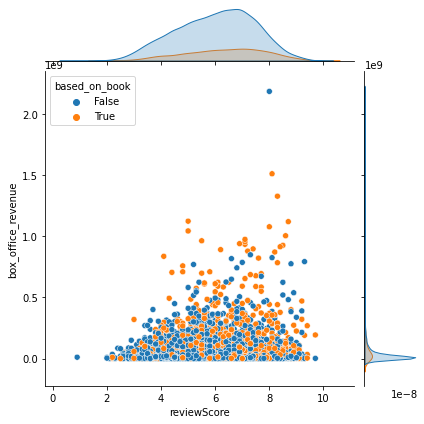

In [ ]:
# Check the distribution of review scores and box revenues for book-based and not book-based films

sns.jointplot(data=books_movies, x='reviewScore', y='box_office_revenue', hue='based_on_book')

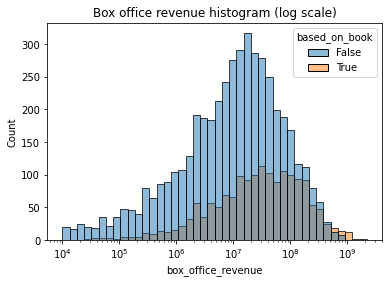

In [ ]:
# Log scale is better for representing box office revenue

sns.histplot(data=books_movies, x='box_office_revenue', hue='based_on_book', log_scale=True)
plt.title('Box office revenue histogram (log scale)')
plt.show()